# Nested Sampling with `dynesty`: Dynamic Nested Sampling

This is a simple interactive demo that outlines **dynamic nested sampling** in `dynesty`. This is meant to be a living document that will eventually get turned into documentation at some point in the future.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(5)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

# Target Distribution

For this demonstration, we will return to the **correlated multivariate normal** case used earlier with a uniform prior from $[-10, 10]$.

In [4]:
ndim = 3  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

# Quick Review

**Bayes' Rule** states that given some **data** $\mathbf{D}$ and **model** $M$ with **parameters** $\boldsymbol{\Theta}$ we can write the **posterior** $P(\boldsymbol{\Theta} | \mathbf{D}, M)$ as

$$ P(\boldsymbol{\Theta} | \mathbf{D}, M) = \frac{P(\mathbf{D} | \boldsymbol{\Theta}, M) P(\boldsymbol{\Theta} | M)}{P(\mathbf{D} | M)} $$

where $P(\mathbf{D} | \boldsymbol{\Theta}, M) \equiv \mathcal{L}(\boldsymbol{\Theta})$ is the **likelihood**, $P(\boldsymbol{\Theta}| M) \equiv \pi(\boldsymbol{\Theta})$ is the **prior**, and 

$$ P(\mathbf{D} | M) \equiv \mathcal{Z} = \int_{\Omega_{\boldsymbol{\Theta}}} \mathcal{L}(\boldsymbol{\Theta}) \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

is the **evidence**, where the integral is taken over the entire domain $\Omega_{\boldsymbol{\Theta}}$ of $\boldsymbol{\Theta}$ (i.e. over all possible $\boldsymbol{\Theta}$).

**Nested sampling** [(Skilling 2006)](https://projecteuclid.org/euclid.ba/1340370944) is designed to estimate $\mathcal{Z}$ by transforming this N-D integral over all $\boldsymbol{\Theta}$ to a 1-D integral over the **prior volume** 

$$ X(\lambda) \equiv \int_{\boldsymbol{\Theta} : \mathcal{L}(\boldsymbol{\Theta}) > \lambda} \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

contained within an **iso-likelihood contour** set by $\mathcal{L}(\boldsymbol{\Theta}) = \lambda$ such that

$$ \mathcal{Z} = \int_{0}^{+\infty} X(\lambda) \, d\lambda = \int_{0}^{1} \mathcal{L}(X) \, dX $$

assuming $\mathcal{L}(X(\lambda)) = \lambda$ exists. Computing the evidence using these "nested shells" is what gives nested sampling its name.

# "Standard" Nested Sampling

In a given nested sampling run with $K$ live points, the prior volume evolves as

$$ \Delta \ln X_i \approx 1 /K \quad .$$

The **"information"** gained from moving from the prior $\pi(\boldsymbol{\Theta})$ to the posterior $p(\boldsymbol{\Theta})$ can be quantified using the **KL Divergence** between the two distributions,

$$ H \equiv \int_{\Omega_{\boldsymbol{\Theta}}} p(\boldsymbol{\Theta}) \ln\left(\frac{p(\boldsymbol{\Theta})}{\pi(\boldsymbol{\Theta})}\right) \, d\boldsymbol{\Theta} \quad . $$

The number of steps needed for the distribution to start from the prior and integrate over the entire posterior is then roughly $\approx HK$ (with uncertainties likely dominated by Poisson noise). This result highlights one of the main drawbacks of nested sampling: since the number of steps is proportional to the information gained from going from the prior to the posterior, **using less "informative" priors will increase the expected number of nested sampling iterations**.

Another drawback this approximation illustrates is that **the number of expected nested sampling iterations is directly proportional to the number of live points $K$ used.** So while increasing the number of live points ensures we compress the prior volume more slowly, granting us finer posterior resolution, it also increases our runtime.

In addition to affecting the general resolution of our samples, the number of live points also can affect our sampling efficiency and computational overhead. For instance, all of the bounding distributions available in `dynesty` become more robust as we add more live points (i.e. bootstrapping produces smaller volume expansion factors) but also often become more intensive to construct (e.g., `'multi'`) and sample from (e.g., `'cubes'`).

In [5]:
# initialize our "standard" nested sampler
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                bound='single', nlive=1000)

# sample from the distribution
sampler.run_nested(dlogz=0.01)

# grab our results
res = sampler.results

iter: 13139+1000 | nc: 1 | ncall: 49499 | eff(%): 28.564 | logz: -8.818 +/-  0.084 | dlogz:  0.000 <  0.010    


## Drawbacks

In many applications, scientists are often as interested (if not more interested) in estimating the posterior rather than the evidence. From a posterior-oriented perspective, nested sampling's ability to robustly sample from complex, multi-modal distributions often makes it an attractive alternative to methods such as **Markov Chain Monte Carlo (MCMC)**.

The main drawback, however, is that **nested sampling is designed to estimate the evidence, not the posterior**. In particular, one of the main drawbacks of "standard" nested sampling is that we compress *linearly* in $\ln X_i$ at all times, regardless of where the majority of posterior mass is located. We can visualize this behavior directly using `runplot`.

In [6]:
from dynesty import plotting as dyplot

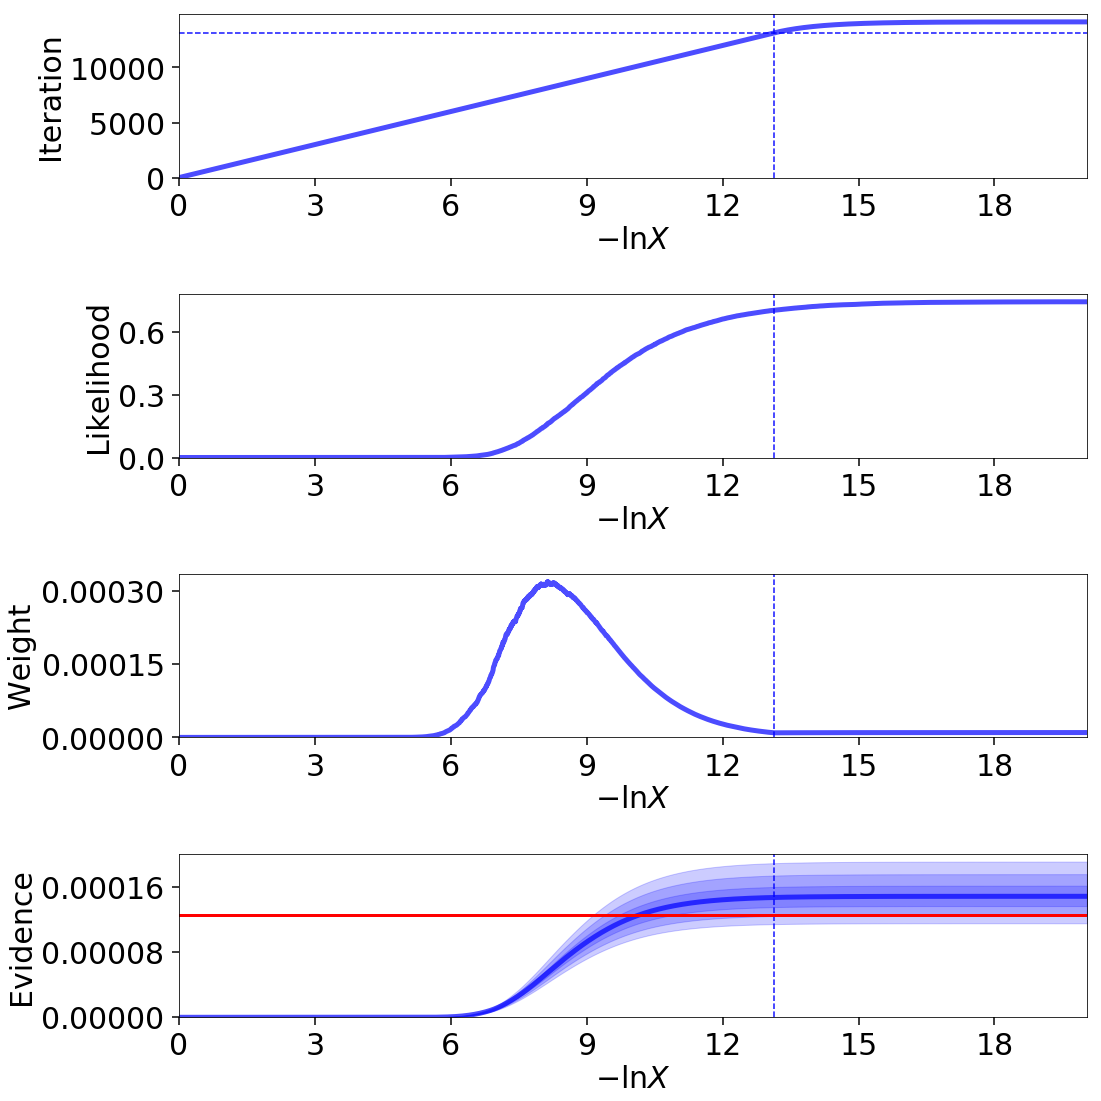

In [7]:
lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(res, lnz_truth=lnz_truth)
fig.tight_layout()

In this particular example, approximately a third of our samples give negligible contributions to the posterior. While these samples are crucial for evidence estimation (since they provide information on the current prior volume $ln X_i$), they are essentially useless when constructing posterior distributions. **As a result, the proportion of "wasted" samples remains approximately constant.** In other words, while increasing the number of live points increases the resolution of samples over the bulk of the posterior...it also increases the resolution everywhere else.

# Dynamic Nested Sampling

Instead of using a constant number of live points $K$ throughout the whole run, [Higson et al. (2017)](https://arxiv.org/abs/1704.03459) proposed allocating live points *dynamically* such that at a given iteration $i$ we have (effectively) $K_i$ live points. Since our prior volume changes as

$$ \Delta \ln X_i \approx 1/K_i \quad , $$

allowing $K_i$ to vary gives us the ability to control the resolution of our sampler. For instance, in a posterior-oriented application, we might allocate fewer samples outside the bulk of the posterior mass. Although this would increase the error on our evidence estimate, it would lead to a decrease in runtime without substantially affecting our posterior estimates.

## Implementation in `dynesty`

Although in theory dynamic sampling can be done by adding one live point at a time, in practice this approach is difficult to implement because the number of points that are "live" can change rapidly as we traverse the prior volume (i.e. as we sample "up" the (log-)likelihood curve). In `dynesty`, we opt to use a perturbative approach, where we insert additional live points in "batches" with some guidance from an original "baseline" run. The schematic nature looks something like this:
1. Compute a set of "baseline" samples using standard nested sampling with $K_0$ live points.
2. Decide whether to stop sampling.
3. If we want to continue sampling, decide where to allocate additional live points.
4. Compute a new set of samples for batch $b$ using standard nested sampling with $K_b$ live points.
5. "Combine" the new batch with the set of previous samples and return to (2).

## Adding Samples

While dynamic sampling is powerful, the additional flexibility requires introducing two more sets of (hyper-)parameters. The first set is associated with a **weight function**, which takes the current set of dead points (samples) and decides where we wish to allocate additional samples. 

The default weight function used in `dynesty` is

$$ I_i(f_p) = f_p I^p_i + (1-f_p) I^{\mathcal{Z}}_i $$

where $f_p$ is the relative fractional importance we place on posterior estimation, $I_i^p = \hat{p}_i / \sum_j \hat{p}_j$ is the normalized posterior importance weight, $I^{\mathcal{Z}}_i = (1 - \hat{\mathcal{Z}}_i / \hat{\mathcal{Z}}_{\textrm{est}}) / K_i$ is the normalized evidence weight, $\hat{\mathcal{Z}}_{\textrm{est}}$ is the estimated total evidence (i.e. including the remainder), and $K_i$ is the number of live points at (effective) iteration $i$. The likelihood ranges where we will add new dead points is then specified by taking the minimum and maximum iterations $i_\min$ and $i_\max$ that satisfy 

$$ I_i(f_p) \geq f_{\max} \times \max(\lbrace \dots, I_i(f_p), \dots \rbrace) $$

with some additional left/right padding of $\pm n_{\textrm{pad}}$ indices (where $i_\min \leq 0$ defaults to $0$ and $i_\max > N$ defaults to $N$). The default values are $f_p=0.8$, $f_\max = 0.8$, and $n_{\textrm{pad}} = 1$.

## Stopping Criteria

The second set of hyper-parameters is associated with a **stopping function**, which takes the current set of dead points and decides when we should stop sampling. The default combined posterior/evidence stopping criterion is

$$ S \equiv f_p \times \left[ \frac{\sigma(\lbrace D_{p^\prime || p}^{(1)}, \dots, D_{p^\prime || p}^{(n)} \rbrace)}{\left\langle(\lbrace D_{p^\prime || p}^{(1)}, \dots, D_{p^\prime || p}^{(n)})\right\rangle} \sigma_{p, \max}^{-1} \right] + (1-f_p) \times \left[\sigma(\lbrace \ln \hat{\mathcal{Z}}_1^\prime, \dots, \ln \hat{\mathcal{Z}}_n^\prime \rbrace)\sigma_{\ln\hat{\mathcal{Z}},\max}^{-1}\right] < 1 $$

where $f_p$ is the fractional importance we place on posterior estimation, the $\prime$ indicates quantities generated from a "realization" of our run, $D_{p^\prime || p}$ is the Kullback-Leibler divergence from $p$ (our default run) to $p^\prime$ (our "realization"), $\sigma_{p, \max}$ is the posterior "error threshold", $\sigma_{\ln \hat{\mathcal{Z}}, \max}$ is the evidence error threshold, and $n$ is the total number of realizations used to generate our estimates. The default values of these are $f_p = 1$, $\sigma_{p, \max} = 0.02$, $\sigma_{\ln \hat{\mathcal{Z}}, \max} = 0.1$, and $n=32$. (Users can also choose a method used to generate the realizations.)

### Posterior Term

The default posterior stopping criteria uses the [**Kullback-Leibler (KL) divergence**](https://en.wikipedia.org/wiki/Kullback-Leibler_divergence) between the full set of dead points (which forms the "baseline" distribution) and a "realized" set of dead points (which includes resampling particles and simulating statistical uncertainties). This is defined as

$$ D_{p^\prime || p} = \int_{\Omega_{\boldsymbol{\Theta}}} p^\prime(\boldsymbol{\Theta}) \ln \left(\frac{p^\prime(\boldsymbol{\Theta})}{p(\boldsymbol{\Theta})}\right) \, d\boldsymbol{\Theta} 
\approx \sum_i \hat{p}^\prime_i \ln \hat{p}^\prime_i - \sum_i \hat{p}^\prime_i \ln \hat{p}_i $$

where the sum over $i$ is taken over all "realized" dead points (i.e. samples), $\hat{p}_i$ is the importance weight of the original set of points, and $\hat{p}^\prime_i$ is the importance weight computed of the "realized" set of dead points. Since all samples are defined on the same domain, this discrete sum gives an estimate of the divergence between realizations of the posterior and the estimated (mean) posterior. By construction, some level of mean variation is expected due to prior volume uncertainties. Variation *around* the mean, however, is a good indicator of the impact uncertainties can have on our posterior distribution estimates. Sampling stops when

$$ \frac{\sigma(\lbrace\dots, D_{p^\prime || p}, \dots\rbrace)}{\left\langle(\lbrace\dots, D_{p^\prime || p}, \dots\rbrace)\right\rangle} < \sigma_{p, \max} $$

for a provided threshold $\sigma_{p, \max}$.

### Evidence

The default evidence stopping criteria uses the $\ln \hat{\mathcal{Z}}$ realizations from the same sets of dead points as above to compute an estimated error $\sigma(\lbrace\dots, \ln \hat{\mathcal{Z}}_i^\prime, \dots\rbrace)$. Sampling stops when $\sigma(\lbrace\dots, \ln \hat{\mathcal{Z}}_i^\prime, \dots\rbrace) < \sigma_{\ln\hat{\mathcal{Z}},\max}$ for a provided threshold $\sigma_{\ln\hat{\mathcal{Z}},\max}$.

## Additional Options

Note that while the functions above are used by default, `dynesty` actually allows users to specify their own functions for adding samples and deciding when to stop. 

Like `NestedSampler`, `DynamicNestedSampler` allows users to specify stopping criteria based on: 
- the total maximum number of iterations and log-likelihood calls during the course of the entire run (`maxiter`, `maxcall`),
- the maximum number of iterations and log-likelihood calls during the course of the initial run (`maxiter_init`, `maxcall_init`; default is no limit),
- the remaining $\Delta \ln \hat{\mathcal{Z}}$ after the initial run (`dlogz_init`; default is 0.01),
- the maximum number of iterations and log-likelihood calls while adding batches (`maxiter_batch`, `maxcall_batch`), and
- the maximum number of batches to add (`maxbatch`; default is no limit).

## Usage

Dynamic sampling in `dynesty` is implemented using the `DynamicNestedSampler` class (in contrast to the `NestedSampler` classes used above). Like `NestedSampler`, `DynamicNestedSampler` uses a fixed set of bounding and sampling methods and can be initialized using a very similar API. One key difference, however, is that we don't need to declare the number of live points upon initialization.

In [8]:
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, 
                                        bound='single', sample='unif')

# Performance Comparisons

We'll compare our results using several different test cases to illustrate different aspects of the dynamic nested sampling.

## Case 1: Maximum Resolution

In the first case, we'll use 100 live points to lay down our "baseline" run defining our initial distribution, and then add batches of 100 live points until the maximum possible number of live points at any given iteration is 1000. This means the our dynamic sampling run can only achieve a *possible* maximum resolution equivalent to that maintained throughout our *entire* initial nested sampling run.

As before, we can sample internally using the `run_nested()` function. Since we're targeting a fixed number of samples, we will also disable the use of our stopping criteriona via the `use_stop=False` option.

In [9]:
# sample dynamically from the target distribution
dsampler.run_nested(nlive_init=100, nlive_batch=100, maxbatch=9, use_stop=False)

# save results
dres = dsampler.results

iter: 4115 | batch: 9 | nc: 2 | ncall: 12193 | eff(%): 33.749 | loglstar: -7.329 < -0.309 < -0.836 | logz: -8.494 +/-  0.249 | stop:    nan     


Notice that since we've optimized our dynamic sampler for posterior estimation over evidence estimation (via the default weight function), the errors on our evidence estimates have gotten significantly larger. In addition, notice that our dynamic nested sampler is somewhat less efficient than our original run (40% vs 60%). As discussed above, this is because the robustness of our proposals depends on the number of live points.

Note that the `Results` dictionary from `DynamicNestedSampler` has a slightly different set of stored values than `NestedSampler`:
- **`samples_n`**: gives the number of live points at a given iteration (stored instead of `nlive`).
- **`samples_batch`**: index of the batch the points were sampled from.
- **`batch_nlive`**: tracks the number of live points added in a given batch.
- **`batch_bounds`**: the log-likelihood bounds used to bound the dead points from a given batch.

## Case 2: Equal Number of Samples

For our second case, let's now continue adding batches until our dynamic nested sampler has as many *samples* (i.e. has run for the same number of iterations) as our original "standard" nested sampling run. As with `NestedSampler`, we can continue where we left off (at least on the batch level) by executing `run_nested` again with different stopping criteria. Alternately, we can add individual batches using `add_batch`. We demonstrate using both options below.

In [10]:
# add a batch
dsampler.add_batch(nlive_batch=100)

# add samples in batches until we reach ~ the same number of samples
dsampler.run_nested(nlive_batch=100, maxiter=res.niter+res.nlive, use_stop=False)

# save results
dres2 = dsampler.results

iter: 14223 | batch: 31 | nc: 4 | ncall: 42195 | eff(%): 33.708 | loglstar: -3.108 < -0.466 < -1.058 | logz: -8.868 +/-  0.128 | stop:    nan       


Note that, similar to the `NestedSampler`, our `DynamicNestedSampler` can also add samples externally using generators. The relevant functions to do that are `sample_initial` and `sample_batch`.

## Case 3: Posterior Accuracy

For our third case, we will restart from the beginning and keep adding samples until we satisfy the default stopping criterion outlined above, focusing entirely on posterior accuracy. This means we will overried the default posterior weight $f_p=0.8$ for our weight function with $1.0$ instead, which can be passed via within `wt_kwargs`. Since computing the stopping criterion can require a decent amount of overhead due to the large (varying) number of allocated live points, we'll actually opt to do this in parallel using the same `pool` structure as the previous demo.

In [11]:
# import ipyparallel
import ipyparallel as ipp
rc = ipp.Client()  # create a client
nprocs = len(rc.ids)
dview = rc[:]  # create a `DirectView` object
dview.use_dill();  # use `dill` for advanced pickling

In [12]:
%%px

# import environment
from __future__ import division, print_function
from builtins import range
import time, sys, os
import numpy as np
import math
from numpy import linalg
import dynesty

# define likelihood constants
ndim = 3
C = np.identity(ndim)
C[C==0] = 0.95
Cinv = linalg.inv(C)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))

# seed the random number generator
np.random.seed(os.getpid())
print(os.getpid())

[stdout:0] 29180
[stdout:1] 29182
[stdout:2] 29184
[stdout:3] 29188
[stdout:4] 29199
[stdout:5] 29210
[stdout:6] 29221
[stdout:7] 29232


In [13]:
class Pool(object):
    """A simple wrapper for `dview`."""
    
    def __init__(self, dview):
        self.dview = dview
        
    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

# define our pool
pool = Pool(dview)

In [14]:
# add samples in batches until we satisfy the default stopping criterion
psampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, 
                                        bound='single', sample='unif',
                                        pool=pool, queue_size=nprocs,
                                        use_pool={'propose_point': False})
psampler.run_nested(nlive_init=100, nlive_batch=100, wt_kwargs={'pfrac': 1.0})

# save results
dres3 = psampler.results

iter: 10151 | batch: 24 | nc: 4 | ncall: 22827 | eff(%): 44.469 | loglstar: -7.317 < -0.317 < -0.989 | logz: -9.278 +/-  0.261 | stop:  1.373    


## Case 4: Evidence Accuracy

For our fourth case, we will restart from the beginning and keep adding samples until we satisfy the default stopping criterion outlined above, focusing entirely on evidence accuracy. Since our stopping function by default uses $f_p=1.0$, we'll also replace that with $0.0$ via `stop_kwargs`.

In [15]:
# add samples in batches until we satisfy the default stopping criterion
psampler.reset()
psampler.run_nested(nlive_init=100, nlive_batch=100,
                    wt_kwargs={'pfrac': 0.0}, stop_kwargs={'pfrac': 0.0})

# save results
dres4 = psampler.results

iter: 11673 | batch: 11 | nc: 1 | ncall: 57339 | eff(%): 20.358 | loglstar:   -inf < -0.328 < -1.338 | logz: -9.026 +/-  0.086 | stop:  1.372       


# Visualizing Results

First, let's take a look at how the number of live points changes over the course of our runs.

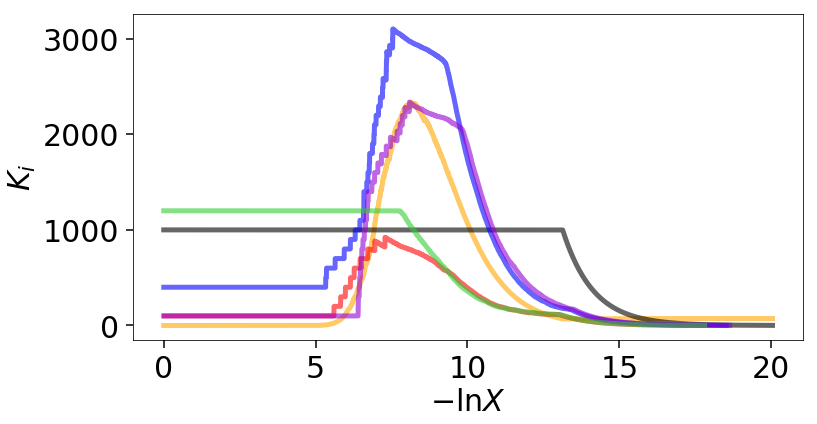

In [16]:
# set up figure
plt.figure(figsize=(12, 6))
plt.xlabel(r'$-\ln X$')
plt.ylabel(r'$K_i$')

# plot scaled posterior mass
plt.plot(-res.logvol, np.exp(res.logwt) / max(np.exp(res.logwt)) * max(dres3.samples_n),
         color='orange', lw=5, alpha=0.6)

# "standard" run
nlive =  np.append(np.ones(res.niter) * res.nlive, np.arange(1, res.nlive + 1)[::-1])
plt.plot(-res.logvol, nlive, lw=5, color='black', alpha=0.6)

# initial dynamic run
plt.plot(-dres.logvol, dres.samples_n, lw=5, color='red', alpha=0.6)

# extended dynamic run
plt.plot(-dres2.logvol, dres2.samples_n, lw=5, color='blue', alpha=0.6)

# posterior-oriented dynamic run
plt.plot(-dres3.logvol, dres3.samples_n, lw=5, color='darkviolet', alpha=0.6)

# evidence-oriented dynamic run
plt.plot(-dres4.logvol, dres4.samples_n, lw=5, color='limegreen', alpha=0.6)

We can see that the general shape of the dynamic runs for Cases 1-3 traces the overall shape of the posterior, as desired, but in general is skewed left. This is primarily due to two reasons. First, the evidence weights are entirely to the left of the majority of the posterior mass, since the more samples we add before hitting the bulk of the posterior increases the accuracy of $w_i=\Delta X_i$ (via the central limit theorem). This explains the behavior for our evidence-oriented result (Case 4). The weighted average between the evidence and posterior weights thus tends to skew the distribution left. The second reason is that because we recycle any live points sampled past the log-likelihood bounds during each batch, we actually are able to get more information "inward" than we expect, skewing our allocation of points "outward".

We can see the impact our samples have on our inference using the same plotting diagnostics as before.

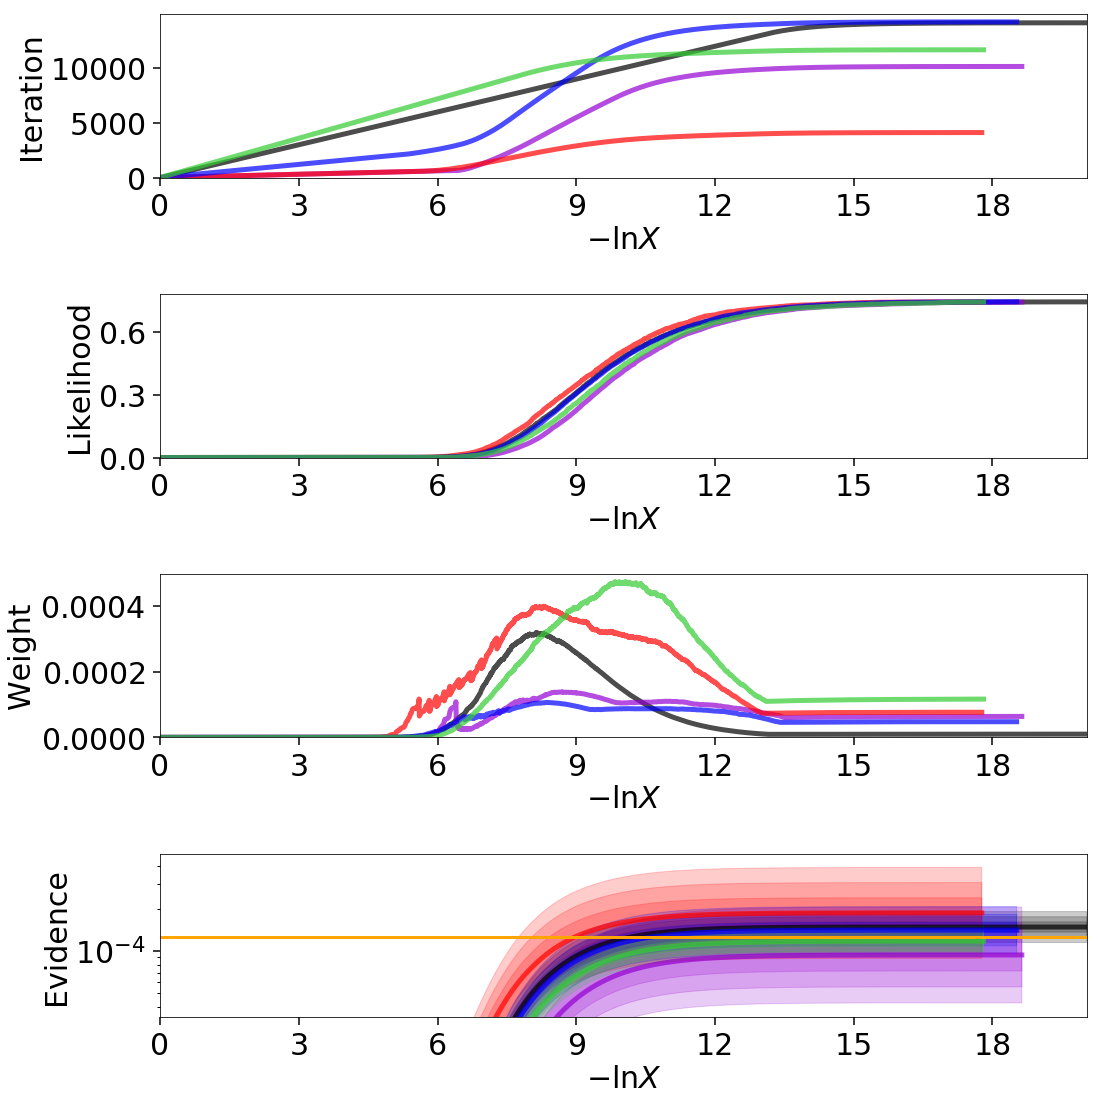

In [17]:
# plot extended run with fixed number of live points
fig, axes = dyplot.runplot(res, color='black', mark_final_live=False, logplot=True)

# overplot posterior-oriented dynamic run
fig, axes = dyplot.runplot(dres3, color='darkviolet', 
                           logplot=True, fig=(fig, axes))

# overplot dynamic run
fig, axes = dyplot.runplot(dres, color='red',
                           logplot=True, fig=(fig, axes))

# overplot extended dynamic run
fig, axes = dyplot.runplot(dres2, color='blue',
                           logplot=True, fig=(fig, axes))

# overplot evidence-oriented dynamic run
fig, axes = dyplot.runplot(dres4, color='limegreen',
                           logplot=True, fig=(fig, axes), 
                           lnz_truth=lnz_truth,  truth_color='orange')

fig.tight_layout()

We see that our dynamic sampler is doing exactly what we want: although we ultimately are generating a similar amount of samples, the places where they are located differs dramatically among our runs. For the posterior-oriented cases, we spend (significantly) less time sampling regions with little posterior weight and with samples concentrated around the bulk of the posterior mass. Conversely, in the evidence-oriented case we spend many fewer samples tracing out the bulk of the posterior mass. 

This behavior can be made more apparent by looking at our results using `traceplot` and `cornerpoints`.

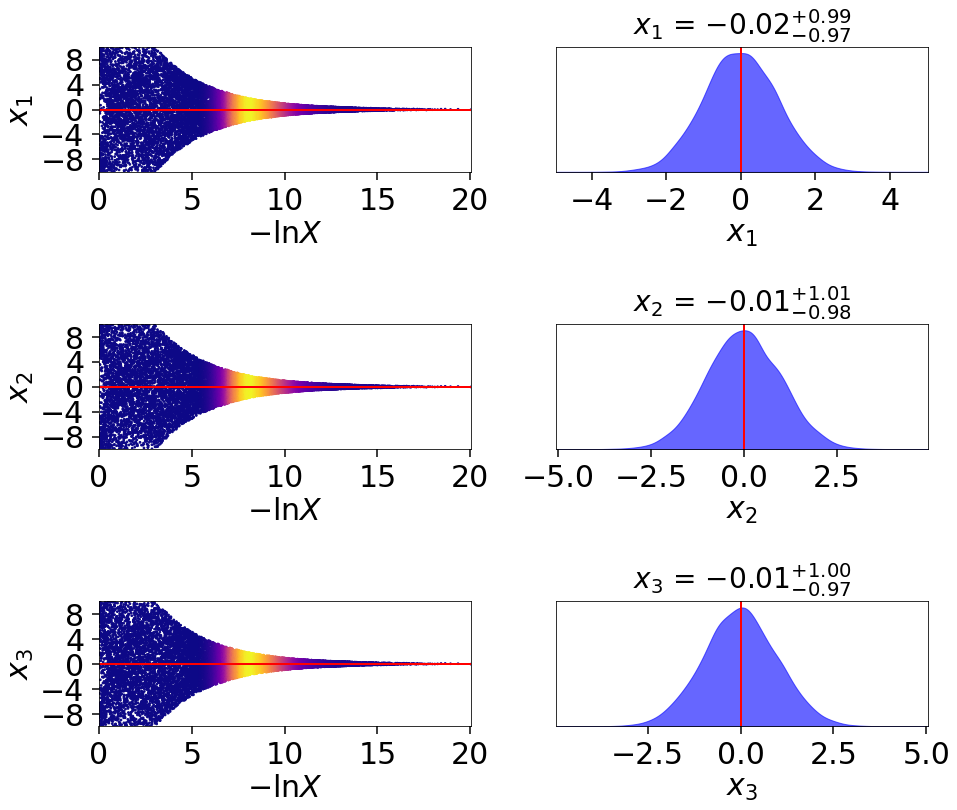

In [18]:
# plotting the standard run
fig, axes = dyplot.traceplot(res, truths=[0., 0., 0.], show_titles=True, trace_cmap='plasma',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

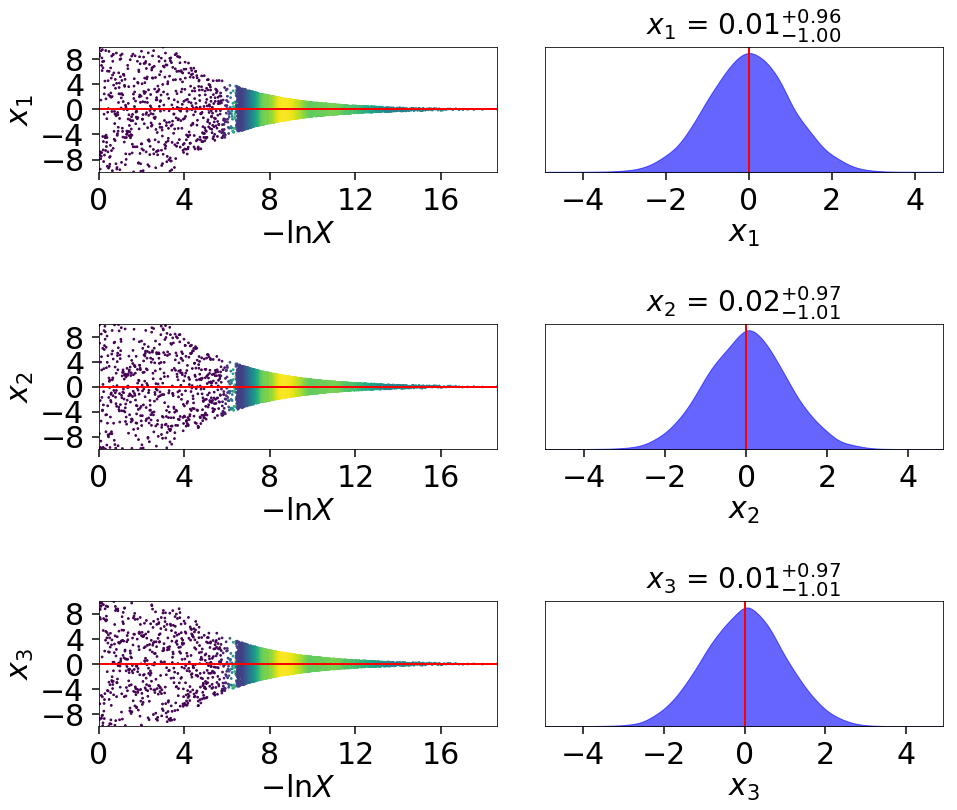

In [19]:
# plotting the posterior-oriented dynamic run
fig, axes = dyplot.traceplot(dres3, truths=[0., 0., 0.], show_titles=True, trace_cmap='viridis',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

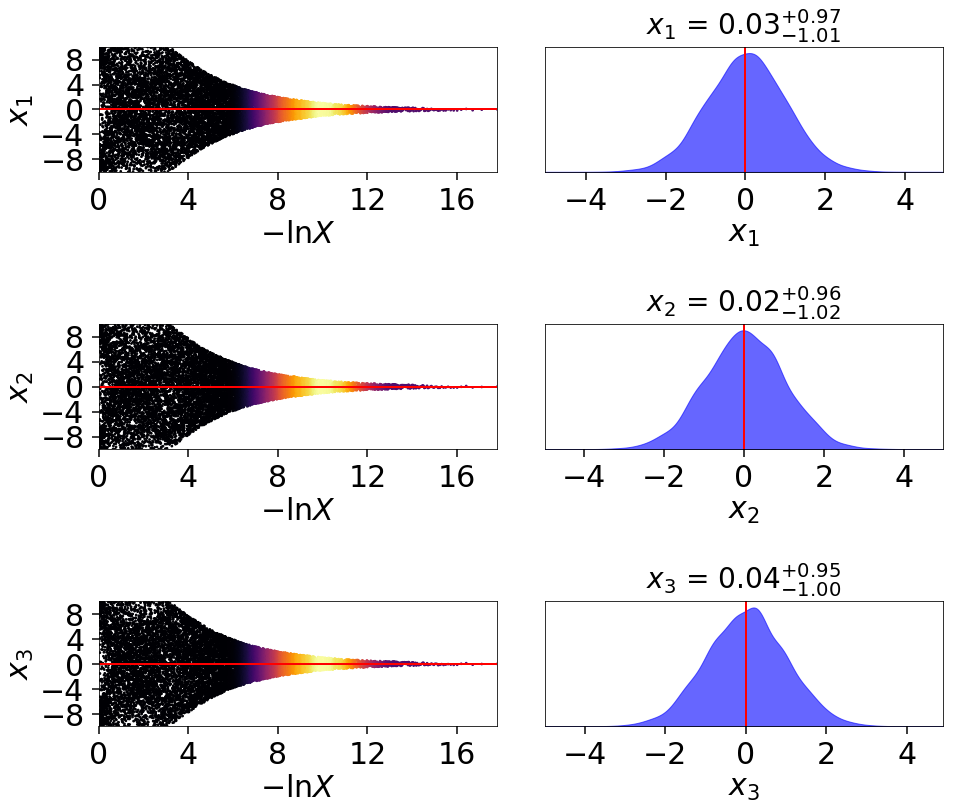

In [20]:
# plotting the evidence-oriented dynamic run
fig, axes = dyplot.traceplot(dres4, truths=[0., 0., 0.], show_titles=True, trace_cmap='inferno',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

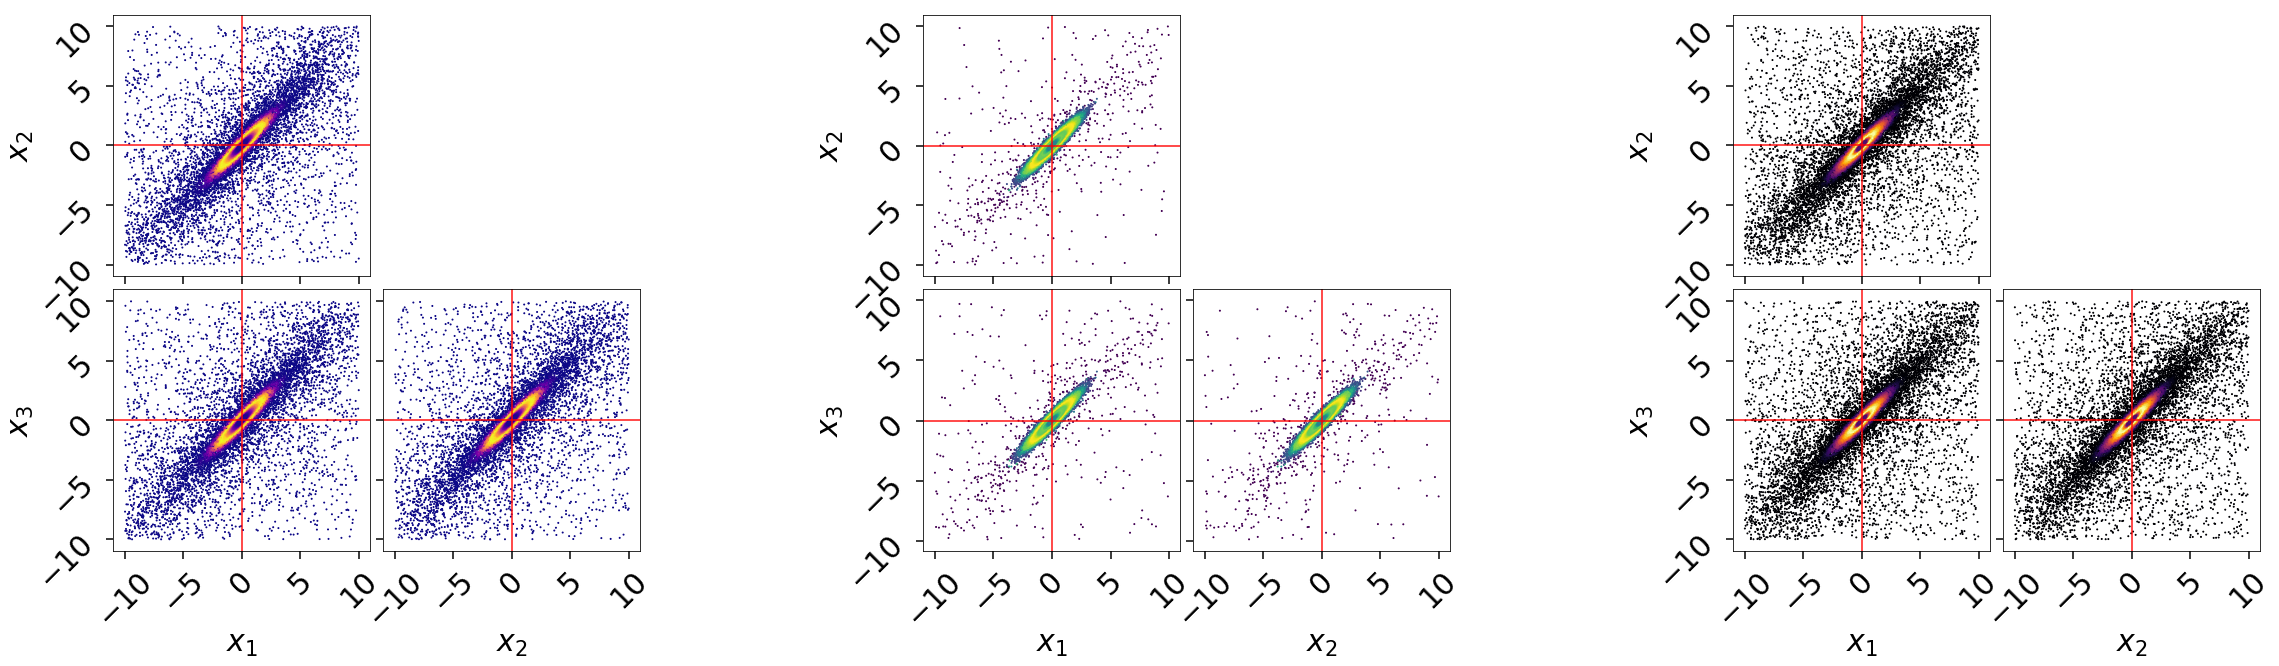

In [21]:
# initialize figure
fig, axes = plt.subplots(2, 8, figsize=(40, 10))
axes = axes.reshape((2, 8))
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]
[a.set_frame_on(False) for a in axes[:, 5]]
[a.set_xticks([]) for a in axes[:, 5]]
[a.set_yticks([]) for a in axes[:, 5]]

# plot standard run (left)
fg, ax = dyplot.cornerpoints(res, cmap='plasma', truths=[0., 0., 0.],
                             fig=(fig, axes[:, 0:2]))

# plot posterior-oriented dynamic run (middle)
fg, ax = dyplot.cornerpoints(dres3, cmap='viridis', truths=[0., 0., 0.],
                             fig=(fig, axes[:, 3:5]))

# plot evidence-oriented dynamic run (right)
fg, ax = dyplot.cornerpoints(dres4, cmap='inferno', truths=[0., 0., 0.],
                             fig=(fig, axes[:, 6:8]))

Finally, let's take a look at how this roughly impacts the quality of our inferred posterior.

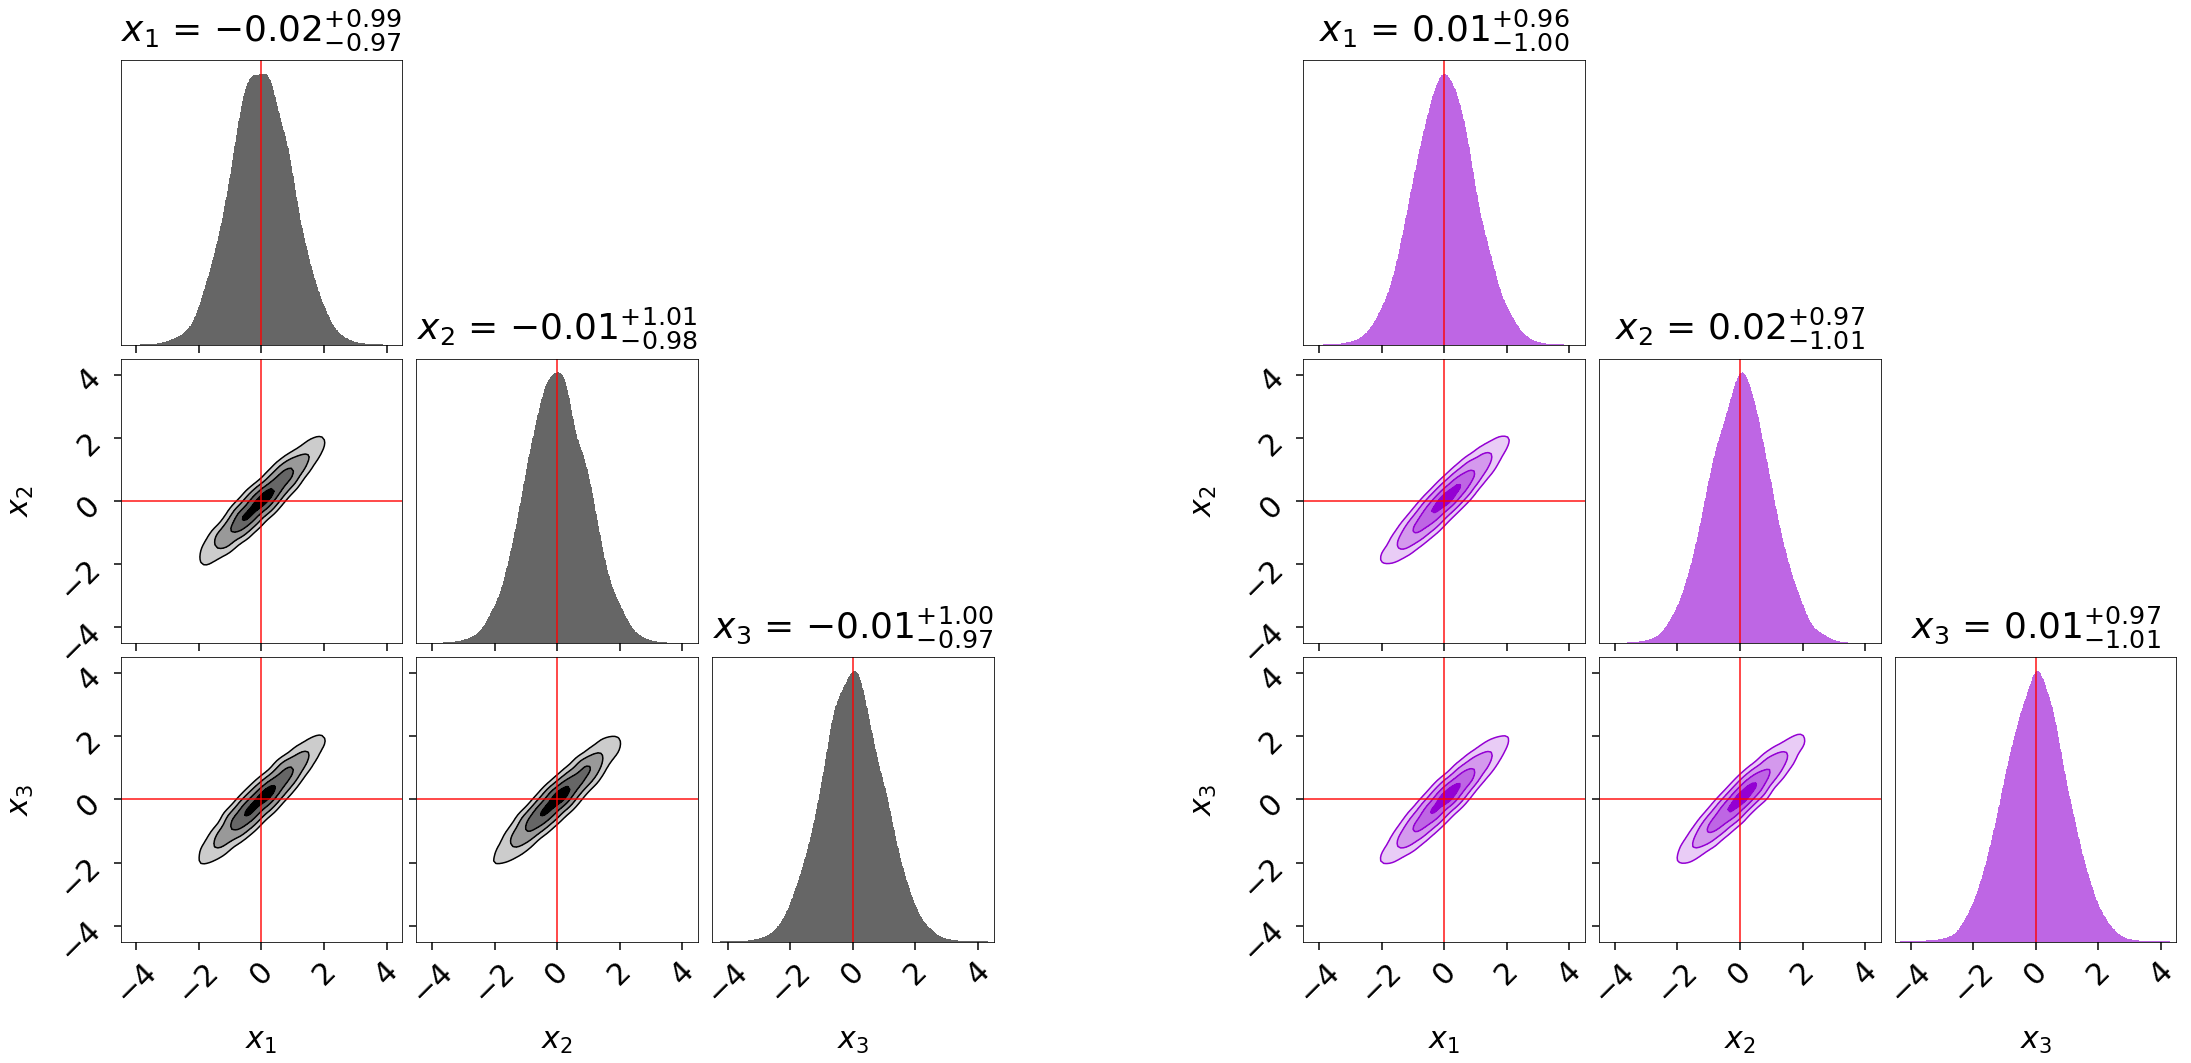

In [22]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot initial run (left)
fg, ax = dyplot.cornerplot(res, color='black', truths=[0., 0., 0.],
                           bounds=[(-4.5, 4.5) for i in range(ndim)],
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot extended run (right)
fg, ax = dyplot.cornerplot(dres3, color='darkviolet', truths=[0., 0., 0.],
                           bounds=[(-4.5, 4.5) for i in range(ndim)],
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, 4:]))

# Summary

"Standard" nested sampling is designed to derive Bayesian evidences with posteriors as a by-product. Dynamic nested sampling builds on this general framework to allocate samples dynamically to prioritize arbitrary weight functions. This allows nested sampling to be used for, e.g., targeted posterior estimation (the default behavior) over evidence calculations. In addition, dynamic nested sampling can also accomodate arbitray stopping criteria, including generalized measures of posterior convergence (the default behavior).